# Neural Style Transfer (NST)

## Import packages

In [14]:
import os
from NST.src import stylization_script, training_script
from NST.utils import utils

## Stylization code

### Define paths

In [15]:
home_dir = os.path.join(os.getcwd())
NST_dir = os.path.join(home_dir, "NST")
content_images_path = os.path.join(home_dir, 'data', 'content-images')
output_images_path = os.path.join(home_dir, 'data', 'output-images')
model_binaries_path = os.path.join(NST_dir, 'models', 'binaries')

### Check binary model path

In [16]:
assert utils.dir_contains_only_models(model_binaries_path), f"Model directory should contain only model binaries."

### Create image output directories if not exists

In [17]:
os.makedirs(output_images_path, exist_ok=True)

### Stylization config

In [18]:
inference_config = {
    'content_images_path': content_images_path,
    'content_input': 'golden_gate.jpg',
    'batch_size': 5,
    'img_width': None,
    'model_binaries_path': model_binaries_path,
    'model_name': 'style_madhubani_datapoints_508100_cw_1.0_sw_400000.0_tw_0.pth',
    'should_not_display': True,
    'verbose': False,
    'output_images_path': output_images_path,
    'redirected_output': None,
    'use_origin_name': True
}

In [19]:
if os.path.isdir(os.path.join(content_images_path, inference_config['content_input'])) and inference_config['redirected_output'] is None:
    inference_config['redirected_output'] = output_images_path

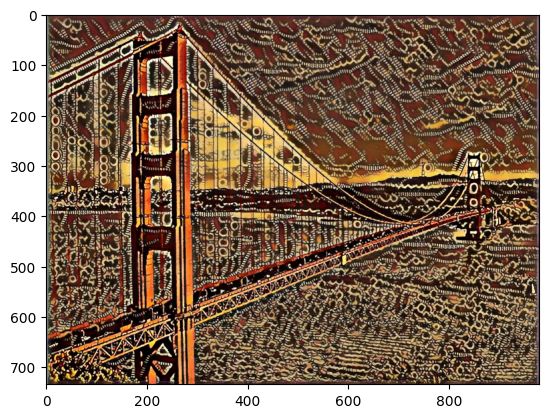

In [20]:
stylization_script.stylize_static_image(inference_config)

## Training code

Note: The training process would take several hours. 

### Define paths

In [21]:
home_dir = os.path.join(os.getcwd())
style_images_path = os.path.join(home_dir, 'data', 'style-images')
model_binaries_path = os.path.join(home_dir, 'NST', 'models', 'binaries')
checkpoints_root_path = os.path.join(home_dir, 'NST', 'models', 'checkpoints')
dataset_path = os.path.join(home_dir, 'data', 'OCH', 'ochuman')

In [22]:
assert os.path.exists(dataset_path), f"OCHuman dataset missing. Please download the OCHuman dataset."

In [23]:
os.makedirs(model_binaries_path, exist_ok=True)

### Training config

In [24]:
style_img_name = 'madhubani.jpg'
image_size = 256
batch_size = 4

In [25]:
checkpoints_path = os.path.join(checkpoints_root_path, style_img_name.split('.')[0])

In [26]:
training_config = {
    'style_images_path': style_images_path,
    'style_img_name': 'madhubani.jpg',
    'content_weight': 1e0,
    'style_weight': 4e5,
    'tv_weight': 0,
    'num_of_epochs': 1,
    'dataset_path': dataset_path,
    'image_size': image_size,
    'batch_size': batch_size,
    'model_binaries_path': model_binaries_path,
    'checkpoints_path': checkpoints_path,
    'subset_size': None,
    'enable_tensorboard': True,
    'image_log_freq': 100,
    'console_log_freq': 100,
    'checkpoint_freq': 500,
}

In [27]:
if training_config['checkpoint_freq'] is not None:
    os.makedirs(checkpoints_path, exist_ok=True)

In [ ]:
training_script.train(training_config)

# Mask RCNN Inference

## Import packages

In [74]:
import os
import torch
from Mask_RCNN.src.ochuman_dataset import OCHumanDataset
from Mask_RCNN.src.utils.misc import collate_fn
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
from json import JSONEncoder
from tqdm import tqdm

## Mask RCNN inference code

In [38]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [67]:
def show_img(index, images, outputs, json_path, output_path, cpu_device=torch.device("cpu")):
    overall_mask = np.zeros((600, 600, 1))
    for i in range(len(outputs)):
        for j in range(len(outputs[i]["masks"])):
            mask = outputs[i]["masks"][j].to(cpu_device).permute(1, 2, 0).detach().numpy()
            overall_mask[mask >= 0.25] = 1
        # print(f"Image ID: {index}, Number of masks: {j + 1}")
        overall_mask[overall_mask > 0] = 1
        overall_mask = np.squeeze(overall_mask)

        img = images[i].to(cpu_device).permute(1, 2, 0).numpy()
        img *= 255

        # add cyan to img and save as new image
        # blend = 0.65
        # cyan = np.full_like(img,(255,255,0))
        # img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
        
        # idx = (overall_mask == 1)
        # img[idx] = img_cyan[idx]

        with open(os.path.join(json_path, f"{index}_{i}.json"),"w") as write_file:
            json.dump(overall_mask, write_file, cls=NumpyArrayEncoder)

        cv2.imwrite(os.path.join(output_path, f"{index}_{i}.jpg"), img[:, :, ::-1])

In [68]:
def show_img_NST(index, images, outputs, output_path, cpu_device=torch.device("cpu")):
    overall_mask = np.zeros((600, 600, 1))
    for i in range(len(outputs)):
        for j in range(len(outputs[i]["masks"])):
            mask = outputs[i]["masks"][j].to(cpu_device).permute(1, 2, 0).detach().numpy()
            mask[mask >= 0.25] = 1
            mask[mask < 0.25] = 0
            overall_mask += mask
            # print(f"Number of masks: {j + 1}")

        img = images[i].to(cpu_device).permute(1, 2, 0).numpy()
        img *= 255

        cv2.imwrite(os.path.join(output_path, f"{index}_{i}.jpg"), img[:, :, ::-1])

In [69]:
def Mask_RCNN_inference(Mask_RCNN_inference_config):
    file_ids = []
    for _, _, file_names in os.walk(Mask_RCNN_inference_config['content_images_path']):
        for file_name in file_names:
            file_ids.append(file_name.split(".")[0])

    file_ids_NST = []
    for _, _, file_names in os.walk(Mask_RCNN_inference_config['NST_images_path']):
        for file_name in file_names:
            file_ids_NST.append(file_name.split(".")[0])

    dataset_test = OCHumanDataset(
        root_dir=Mask_RCNN_inference_config['content_images_path'],
        img_ids=file_ids,
        transforms=None,
        train=False
    )

    dataset_test_NST = OCHumanDataset(
        root_dir=Mask_RCNN_inference_config['NST_images_path'],
        img_ids=file_ids_NST,
        transforms=None,
        train=False
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False,
        num_workers=1,
        collate_fn = collate_fn
    )

    data_loader_test_NST = torch.utils.data.DataLoader(
        dataset_test_NST, 
        batch_size=1,
        shuffle=False,
        num_workers=1,
        collate_fn = collate_fn
    )

    device = torch.device("cuda")
    cpu_device = torch.device("cpu")

    os.makedirs(Mask_RCNN_inference_config['json_output_directory'], exist_ok=True)
    os.makedirs(Mask_RCNN_inference_config['output_origin_path'], exist_ok=True)
    os.makedirs(Mask_RCNN_inference_config['output_NST_path'], exist_ok=True)

    with torch.no_grad():
        model = torch.load(os.path.join(Mask_RCNN_inference_config['model_directory'], Mask_RCNN_inference_config['model_name']))
        model.to(device)
        model.eval()

        with tqdm(total = len(data_loader_test), desc="Preprocessing original images") as pbar:
            for i, (images, targets) in enumerate(data_loader_test):
                images = list(img.to(device) for img in images)
                outputs = model(images)
                show_img(
                    i,
                    images,
                    outputs,
                    json_path=Mask_RCNN_inference_config['json_output_directory'],
                    output_path=Mask_RCNN_inference_config['output_origin_path']
                )
                pbar.update(1)
        with tqdm(total = len(data_loader_test_NST), desc="Preprocessing NST images") as pbar:
            for i, (images, targets) in enumerate(data_loader_test_NST):
                images = list(img.to(device) for img in images)
                outputs = model(images)
                show_img_NST(
                    i,
                    images,
                    outputs,
                    output_path=Mask_RCNN_inference_config['output_NST_path']
                )
                pbar.update(1)

## Mask RCNN inference config

In [70]:
home_dir = os.getcwd()
Mask_RCNN_dir = os.path.join(home_dir, "Mask_RCNN")
data_directory = os.path.join(Mask_RCNN_dir, "data")
content_images_path = os.path.join(data_directory, "origin")
NST_images_path = os.path.join(data_directory, "NST")
model_directory = os.path.join(Mask_RCNN_dir, 'model')
model_name = '100.pth'
output_directory = os.path.join(data_directory, 'out')
json_output_directory = os.path.join(output_directory, 'json')
output_origin_path = os.path.join(output_directory, 'origin')
output_NST_path = os.path.join(output_directory, 'NST')

In [71]:
Mask_RCNN_inference_config = {
    'data_directory': data_directory,
    'content_images_path': content_images_path,
    'NST_images_path': NST_images_path,
    'model_directory': model_directory,
    'model_name': model_name,
    'output_directory': output_directory,
    'json_output_directory': json_output_directory,
    'output_origin_path': output_origin_path,
    'output_NST_path': output_NST_path
}

In [72]:
Mask_RCNN_inference(Mask_RCNN_inference_config)

Preprossing NST images: 100%|██████████| 19/19 [00:05<00:00,  3.37it/s]


# Combine Mask RCNN result with NST

In [75]:
import shutil

## Combine code

In [160]:
def combine(config):
    stylization_config = {
        'content_images_path': config['NST_content_images_path'],
        'content_input': config['NST_content_input'],
        'batch_size': config['NST_batch_size'],
        'img_width': config['NST_img_width'],
        'model_binaries_path': config['NST_model_binaries_path'],
        'model_name': config['NST_model_name'],
        'should_not_display': config['NST_should_not_display'],
        'verbose': config['NST_verbose'],
        'output_images_path': config['NST_output_images_path'],
        'redirected_output': config['NST_redirected_output'],
        'use_origin_name': config['NST_use_origin_name']
    }
    assert utils.dir_contains_only_models(stylization_config['model_binaries_path']), f"NST model directory should contain only model binaries."
    os.makedirs(stylization_config['output_images_path'], exist_ok=True)
    if os.path.isdir(os.path.join(stylization_config['content_images_path'], stylization_config['content_input'])) and stylization_config['redirected_output'] is None:
        stylization_config['redirected_output'] = stylization_config['output_images_path']
    if stylization_config['redirected_output'] is not None:
        os.makedirs(stylization_config['redirected_output'], exist_ok=True)

    stylization_script.stylize_static_image(stylization_config)

    Mask_RCNN_temp_data_directory = os.path.join(config['Mask_RCNN_data_directory'], 'temp')
    content_images_path = os.path.join(Mask_RCNN_temp_data_directory, 'origin')
    os.makedirs(os.path.join(content_images_path, 'images', 'test'), exist_ok=True)
    NST_images_path = os.path.join(Mask_RCNN_temp_data_directory, 'NST')
    os.makedirs(os.path.join(NST_images_path, 'images', 'test'), exist_ok=True)
    output_directory = os.path.join(Mask_RCNN_temp_data_directory, 'out')
    json_output_directory = os.path.join(output_directory, 'json')
    output_origin_path = os.path.join(output_directory, 'origin')
    output_NST_path = os.path.join(output_directory, 'NST')

    Mask_RCNN_config = {
        'data_directory': config['Mask_RCNN_data_directory'],
        'content_images_path': content_images_path,
        'NST_images_path': NST_images_path,
        'model_directory': config['Mask_RCNN_model_directory'],
        'model_name': config['Mask_RCNN_model_name'],
        'output_directory': output_directory,
        'json_output_directory': json_output_directory,
        'output_origin_path': output_origin_path,
        'output_NST_path': output_NST_path
    }

    if os.path.isdir(os.path.join(stylization_config['content_images_path'], stylization_config['content_input'])):
        for file in os.listdir(os.path.join(stylization_config['content_images_path'], stylization_config['content_input'])):
            shutil.copy(
                os.path.join(stylization_config['content_images_path'], stylization_config['content_input'], file),
                os.path.join(Mask_RCNN_config['content_images_path'], 'images', 'test', file)
            )
        for file in os.listdir(stylization_config['redirected_output']):
            shutil.copy(
                os.path.join(stylization_config['redirected_output'], file),
                os.path.join(Mask_RCNN_config['NST_images_path'], 'images', 'test', file)
            )
        shutil.rmtree(stylization_config['redirected_output'])
    else:
        shutil.copy(
            os.path.join(stylization_config['content_images_path'], stylization_config['content_input']),
            os.path.join(Mask_RCNN_config['content_images_path'], 'images', 'test', '000000.jpg')
        )
        shutil.copy(
            os.path.join(stylization_config['redirected_output'], '000000.jpg'),
            os.path.join(Mask_RCNN_config['NST_images_path'], 'images', 'test', '000000.jpg')
        )
        shutil.rmtree(stylization_config['redirected_output'])

    Mask_RCNN_inference(Mask_RCNN_config)
    
    img_names = list(map(lambda x: x[:-4], os.listdir(Mask_RCNN_config['output_origin_path'])))
    with tqdm(total = len(img_names), desc="Combining") as pbar:
        for img_name in img_names:
            origin_img = cv2.imread(os.path.join(Mask_RCNN_config['output_origin_path'], img_name + ".jpg"))[:, :, ::-1]
            NST_img=cv2.imread(os.path.join(Mask_RCNN_config['output_NST_path'], img_name + ".jpg"))[:, :, ::-1]
            with open(os.path.join(Mask_RCNN_config['json_output_directory'], img_name + ".json")) as f:
                mask = np.array(json.load(f))
            mask_index = np.where(mask == config['mask_on_human'])
            NST_img[mask_index] = origin_img[mask_index]
            if config['display']:
                plt.figure(figsize = (5, 5))
                plt.imshow(NST_img)
            if config['mask_on_human']:
                # True means human style does not change
                output_dir = os.path.join(config['output_dir'], config['NST_model_name'].split('.')[0], "mask on human")
            else:
                output_dir = os.path.join(config['output_dir'], config['NST_model_name'].split('.')[0], "mask on background")
            os.makedirs(output_dir, exist_ok=True)
            cv2.imwrite(os.path.join(output_dir, img_name + ".jpg"), NST_img[:, :, ::-1])
            pbar.update(1)
    
    shutil.rmtree(Mask_RCNN_temp_data_directory)
    print(f"The results are stored in {output_dir}")

## Config

In [165]:
home_dir = os.path.join(os.getcwd())
NST_dir = os.path.join(home_dir, "NST")
NST_content_images_path = os.path.join(home_dir, 'data', 'content-images')
NST_output_images_path = os.path.join(home_dir, 'data', 'output-images')
NST_model_binaries_path = os.path.join(NST_dir, 'models', 'binaries')

Mask_RCNN_dir = os.path.join(home_dir, "Mask_RCNN")
Mask_RCNN_model_directory = os.path.join(Mask_RCNN_dir, 'model')
Mask_RCNN_model_name = '100.pth'
Mask_RCNN_data_directory = os.path.join(Mask_RCNN_dir, "data")

output_dir = os.path.join(home_dir, "data", "combined-result")
os.makedirs(output_dir, exist_ok=True)

In [163]:
config = {
    'NST_content_images_path': NST_content_images_path,
    'NST_content_input': '000072.jpg',
    'NST_batch_size': 5,
    'NST_img_width': None,
    'NST_model_binaries_path': NST_model_binaries_path,
    'NST_model_name': 'och_vg_starry_night_200.pth',
    'NST_should_not_display': False,
    'NST_verbose': False,
    'NST_output_images_path': output_images_path,
    'NST_redirected_output': os.path.join(NST_output_images_path, 'madhubani'),
    'NST_use_origin_name': True,

    'Mask_RCNN_data_directory': Mask_RCNN_data_directory,
    'Mask_RCNN_model_directory': Mask_RCNN_model_directory,
    'Mask_RCNN_model_name': Mask_RCNN_model_name,
    
    'output_dir': output_dir,
    'mask_on_human': True,
    'display': False
}

In [164]:
combine(config)

Combining: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

The results are stored in g:\Python Projects\Neural-Style-Transfer-with-Instance-Segmentation\data\test\och_vg_starry_night_200\mask on human
